In [1]:
%load_ext autoreload
%autoreload 2

main.ipynb

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))
from utils import *

In [5]:
os.getcwd()

'/Users/Laure/Desktop/Data_analysis_for_Laure/data-science/Denoising'

In [4]:
data = pd.read_csv(os.getcwd() + '/Raw_from_LLB/' + 'output.csv')

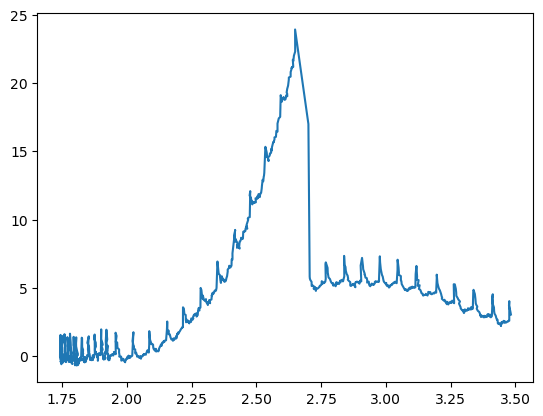

In [5]:
plt.plot(data.distance, data.force)

## Denoising

From Mistral


>Signal denoising is a crucial step in many signal processing applications. The effectiveness of a denoising method depends on the characteristics of the signal and the type of noise present. Here are some commonly used methods for signal denoising in Python:
>
>1. **Moving Average Filter**:
>  - Simple and effective for reducing random noise.
>  - Averages the signal over a specified window size.
>
>2. **Savitzky-Golay Filter**:
>  - Applies polynomial smoothing to the signal.
>  - Preserves the shape and features of the signal better than simple moving average filters.
>
>3. **Wavelet Transform**:
>  - Decomposes the signal into different frequency components.
>  - Allows for thresholding to remove noise while retaining important signal features.
>
>4. **Fourier Transform**:
>  - Converts the signal to the frequency domain.
>  - Allows for filtering out high-frequency noise components.
>
>5. **Kalman Filter**:
>   - Useful for real-time applications where the signal is continuously updated.
>   - Provides an estimate of the signal by predicting and updating based on the noise characteristics.
>
>6. **Low-Pass Filters**:
>   - Filters out high-frequency noise.
>   - Can be implemented using various techniques like Butterworth or Chebyshev filters.
>
>7. **Total Variation Denoising**:
>   - Minimizes the total variation of the signal.
>   - Effective for piecewise-constant signals.
>
>8. **Non-Local Means Denoising**:
>   - Uses the redundancy of patterns in the signal.
>   - Effective for signals with repetitive structures.
>
>The choice of method depends on the specific requirements and constraints of your application. For example, if preserving the signal's features is crucial, the Savitzky-Golay filter might be more appropriate. If real-time processing is needed, the Kalman filter could be a better choice.*

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, filtfilt
import pywt
from sklearn.metrics import mean_squared_error

In [7]:
# Define SNR function
def calculate_snr(original, denoised):
    signal_power = np.sum(original**2)
    noise_power = np.sum((original - denoised)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Moving Average Filter
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# Savitzky-Golay Filter
def savitzky_golay(signal, window_size=11, polyorder=2):
    return savgol_filter(signal, window_size, polyorder)

# Wavelet Denoising
def wavelet_denoising(signal, wavelet='db1', level=1): # wavelet = ['haar', 'db{n}', 'symN', 'coifN', 'dmey']
    coeff = pywt.wavedec(signal, wavelet, mode='zero')
    sigma = np.median(np.abs(coeff[-level]))
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = (pywt.threshold(c, value=uthresh, mode='hard') for c in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='zero')

# Fourier Transform Denoising
def fourier_denoising(signal, cutoff=0.1):
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    fft[np.abs(freqs) > cutoff] = 0
    return np.fft.ifft(fft).real

# Butterworth Low-Pass Filter
def butter_lowpass(signal, cutoff=0.1, fs=500, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)


In [8]:
x = data.distance
y = data.force

xf = 1/(x[0]-x[1]) # sampling frequency

noisy_signal = y

In [ ]:
# Apply denoising methods
denoised_signals = {
    "Moving Average": moving_average(noisy_signal, window_size=int(np.rint(len(noisy_signal)*0.05))),
    "Savitzky-Golay": savitzky_golay(noisy_signal, window_size=int(np.rint(len(noisy_signal)*0.05)), polyorder=2),
    "Wavelet": wavelet_denoising(noisy_signal, wavelet='haar', level=3),
    "Fourier": fourier_denoising(noisy_signal, cutoff=2*(1/xf)),
    "Butterworth": butter_lowpass(noisy_signal, cutoff=int(np.rint(xf*0.1)), fs=xf, order=5),
}

TypeError: rint() takes from 1 to 2 positional arguments but 0 were given

In [36]:
# Adjust the length of denoised signals to match the length of 't'
for method in denoised_signals:
    if len(denoised_signals[method]) != len(x):
        denoised_signals[method] = denoised_signals[method][:len(x)]

In [54]:
"""
# Calculate SNR and MSE for each method
results = {}
for method, denoised in denoised_signals.items():
    snr = calculate_snr(noisy_signal, denoised)
    mse = mean_squared_error(noisy_signal, denoised)
    results[method] = {'SNR': snr, 'MSE': mse}

results
"""

"\n# Calculate SNR and MSE for each method\nresults = {}\nfor method, denoised in denoised_signals.items():\n    snr = calculate_snr(noisy_signal, denoised)\n    mse = mean_squared_error(noisy_signal, denoised)\n    results[method] = {'SNR': snr, 'MSE': mse}\n\nresults\n"

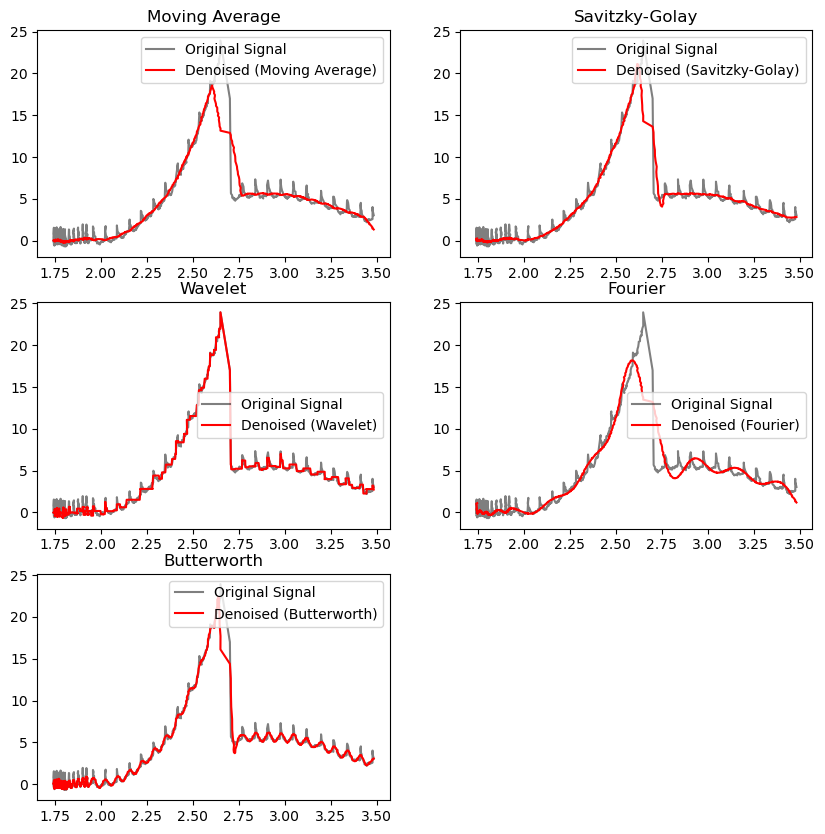

In [37]:
# Plot the results
plt.figure(figsize=(10, 10))
for i, (method, denoised) in enumerate(denoised_signals.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(x, y, label='Original Signal', alpha=0.5, color='black')
    plt.plot(x, denoised, label=f'Denoised ({method})', color='red')
    plt.title(method)
    plt.legend()
#plt.tight_layout()
plt.show()

In [34]:
len(x)

1027